# # Training the model

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization,Lambda, SpectralNormalization as SN, Conv1D, \
                                    UpSampling1D, Embedding, Multiply, Activation, ReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.activations import gelu as GELU
# from tensorflow.keras.layers import GELU, SpectralNormalization as SN

2024-12-06 15:04:20.393872: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 15:04:20.403723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-06 15:04:20.414061: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-06 15:04:20.417151: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 15:04:20.426021: I tensorflow/core/platform/cpu_feature_guar

In [3]:
%matplotlib inline
file_name = 'cWGAN_GP_SN'
dir_name = file_name + '_dir'
ckpt_dir = dir_name + '/ckpt'
plots_dir = dir_name + '/plots'
# os.mkdir(dir_name)
# os.mkdir(ckpt_dir)
# os.mkdir(plots_dir)

In [4]:
data = np.load('../../../data/processed/full_data.npz')
electrical_data = data['electrical_data']
labels = data['labels']

In [6]:
electrical_data

array([[[-0.51989767, -0.55630816, -0.48348718, ..., -0.44293913,
         -0.49920989, -0.51451885],
        [-0.51989767, -0.51989765, -0.56716965, ..., -0.41704086,
         -0.45268978, -0.51451885],
        [-0.27836103, -0.27836103, -0.27836103, ..., -0.27836103,
         -0.27836103, -0.27836103],
        [-0.40422626, -0.40401955, -0.40381167, ..., -0.40483931,
         -0.40463614, -0.40443179],
        [-0.51857042, -0.517959  , -0.51725603, ..., -0.51989047,
         -0.51953279, -0.51909387],
        [-0.50124039, -0.51015859, -0.51877013, ..., -0.46965565,
         -0.48039953, -0.49136323]],

       [[-0.1157974 , -0.14234449, -0.19189904, ..., -0.41666432,
         -0.37241918, -0.41666432],
        [-0.1157974 , -0.11579741, -0.13803255, ..., -0.43302827,
         -0.42152551, -0.41666432],
        [-0.01075784, -0.01075784, -0.01075784, ..., -0.01075784,
         -0.01075784, -0.01075784],
        [-0.29797326, -0.29757247, -0.29716813, ..., -0.29915427,
         -0.29

In [5]:
labels

array([[ 0,  4, 13, 17, 20],
       [ 0,  3, 15, 17, 20],
       [ 2,  7, 12, 17, 24],
       ...,
       [ 0,  3, 14, 18, 21],
       [ 0,  3, 14, 17, 20],
       [ 0,  3, 14, 17, 22]])

## Define cWGAN-GP-SN Monitor Callback

In [4]:
class cWGAN_GP_SN_Monitor(Callback):
    def on_epoch_end(self, epoch, logs=None):
        epoch += 1
        if epoch % 20 == 0:
            # print('\nSaving the generator at epoch', epoch)
            # self.model.generator.save_weights(ckpt_dir + '/generator_weights_' + str(epoch) + '.h5')
            
            # print('Saving the critic at epoch', epoch)
            # self.model.critic.save_weights(ckpt_dir + '/critic_weights_' + str(epoch) + '.h5')
            
            print('Plotting generated samples')
            self.model.save_plots(epoch)

## Define cWGAN-GP-SN Class

In [5]:
class cWGAN_GP_SN(Model):
    def __init__(self, batch_size):
        super(cWGAN_GP_SN, self).__init__()
        
        # Constants and Shapes
        self.batch_size = batch_size
        self.gp_weight = 10
        self.nr_labels = 5
        self.max_labels = 28
        self.noise_length = 144
        self.seq_length = 8760
        self.nr_features = 6
        self.emb_length = 50
        self.gen_input_shape = (self.noise_length, self.nr_features)
        self.critic_input_shape = (self.seq_length, self.nr_features)
        
        # The Generator
        self.generator = self.build_generator()
        self.generator.summary()
        
        # The Critic
        self.c_steps = 5
        self.critic = self.build_critic()
        self.critic.summary()
        
    def compile(self):
        super(cWGAN_GP_SN, self).compile()
        self.c_optimizer = Adam(2e-4, 0.5, 0.9)
        self.g_optimizer = Adam(2e-4, 0.5, 0.9)
        self.c_loss_fn = self.critic_loss
        self.g_loss_fn = self.generator_loss
        
    def gradient_penalty(self, batch_size, real_samples, gen_samples, labels):
        # Get the interpolated data
        alpha = tf.random.normal([batch_size, 1, 1])
        interpolated = real_samples + alpha * (gen_samples - real_samples)

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the critic output for this interpolated data
            pred = self.critic([interpolated, labels], training=True)

        # 2. Calculate the gradients w.r.t to this interpolated data.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        sm = tf.reduce_sum(tf.square(grads), axis=[1, 2])
        mx = tf.maximum(sm, 1e-17)
        norm = tf.sqrt(mx)
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
    
    def train_step(self, data):
        real_samples, labels = data
        real_samples = tf.transpose(real_samples, perm=[0, 2, 1])  # (None, 8760, 6)
        # Get the batch size
        batch_size = tf.shape(real_samples)[0]
        
        for i in range(self.c_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal([batch_size, self.noise_length])
            
            with tf.GradientTape() as tape:
                # Generate fake data from the latent vector
                gen_samples = self.generator([random_latent_vectors, labels], training=True)
                # Add noise to gen_samples and real_samples for regularization
                to_add = tf.constant([[[1.0, 1.0, 0.0, 0.0, 0.0, 1.0]]]) * 0.02
                additional_noise = tf.random.normal((batch_size, self.seq_length, self.nr_features)) * to_add
                
                # print(real_samples.shape)
                # Get the scores for the fake data
                fake_scores = self.critic([gen_samples + additional_noise, labels], training=True)
                # Get the scores for the real data
                real_scores = self.critic([real_samples + additional_noise, labels], training=True)

                # Calculate the critic loss using the fake and real data scores
                c_cost = self.c_loss_fn(real_scores, fake_scores)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_samples, gen_samples, labels)
                # Add the gradient penalty to the original critic loss
                c_loss = c_cost + gp * self.gp_weight

            # Get the gradients w.r.t the critic loss
            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            # Update the weights of the critic using the critic optimizer
            self.c_optimizer.apply_gradients(zip(c_gradient, self.critic.trainable_variables))

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal([batch_size, self.noise_length])
        with tf.GradientTape() as tape:
            # Generate fake data using the generator
            gen_samples = self.generator([random_latent_vectors, labels], training=True)
            # Get the critic scores for fake data
            results = self.critic([gen_samples, labels], training=True)
            # Compute penalties for steep fft
            difs1_ord1 = gen_samples[:, 1:, 2] - gen_samples[:, :-1, 2]
            fft1_penalty = tf.reduce_mean(tf.abs(difs1_ord1))
            difs10_ord1 = gen_samples[:, 1:, 3] - gen_samples[:, :-1, 3]
            fft10_penalty = tf.abs(tf.reduce_mean(tf.abs((difs10_ord1[:, 1:] - difs10_ord1[:, :-1]))) - 1.3e-6)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(results) + 100 * fft1_penalty + 10 * fft10_penalty

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
        return {"c_loss": c_loss, "g_loss": g_loss}

    def build_generator(self):
        # Hyperparameters
        momentum = 0.8
        padding = "valid"
        strides = 2
        
        # Input
        noise = Input(shape=(self.noise_length,))
        labels = Input(shape=(self.nr_labels,), dtype='int32')
        label_embedding = SN(Embedding(self.max_labels, self.emb_length, input_length=self.nr_labels))(labels)
        flatten_embedding = Flatten()(label_embedding)
        dense_embedding = SN(Dense(self.noise_length))(flatten_embedding)
        multiplied_data = Multiply()([noise, dense_embedding])
        dense_data = SN(Dense(self.noise_length * self.nr_features))(multiplied_data)
        gen_input = Reshape(self.gen_input_shape)(dense_data)
        print('\nInput shape for the Generator =', gen_input.shape)
        
        # Structure
        model = Sequential() # 144

        model.add(UpSampling1D(input_shape=self.gen_input_shape))
        model.add(SN(Conv1D(1024, kernel_size=12, padding=padding)))
        model.add(BatchNormalization(momentum=momentum))
        model.add(Activation("gelu")) # 277
        
        model.add(UpSampling1D())
        model.add(SN(Conv1D(512, kernel_size=4, padding=padding)))
        model.add(BatchNormalization(momentum=momentum))
        model.add(Activation("gelu")) # 551
        
        model.add(UpSampling1D())
        model.add(SN(Conv1D(256, kernel_size=5, padding=padding)))
        model.add(BatchNormalization(momentum=momentum))
        model.add(Activation("gelu")) # 1098

        model.add(UpSampling1D())
        model.add(SN(Conv1D(128, kernel_size=4, padding=padding)))
        model.add(BatchNormalization(momentum=momentum))
        model.add(Activation("gelu")) # 2193
        
        model.add(UpSampling1D())
        model.add(SN(Conv1D(64, kernel_size=4, padding=padding)))
        model.add(BatchNormalization(momentum=momentum))
        model.add(Activation("gelu")) # 4383
        
        model.add(UpSampling1D())
        model.add(SN(Conv1D(32, kernel_size=5, padding=padding)))
        model.add(BatchNormalization(momentum=momentum))
        model.add(Activation("gelu")) # 8762
        
        model.add(UpSampling1D())
        model.add(SN(Conv1D(32, kernel_size=4, padding=padding, strides=strides)))
        model.add(BatchNormalization(momentum=momentum))
        model.add(Activation("gelu")) # 8761
        
        model.add(UpSampling1D())
        model.add(SN(Conv1D(self.nr_features, kernel_size=4, padding=padding, strides=strides)))
        model.add(Activation("tanh")) # 8760
        model.add(Reshape(self.critic_input_shape)) # Useless
        
        print('Generator Structure:')
        model.build((None,*self.gen_input_shape))
        model.summary()

        # Result
        res = model(gen_input)
        return Model([noise, labels], res, name="generator")

    def build_critic(self):
        # Hyperparameters
        dropout = 0.2
        padding = "causal"
        strides = 2

        # Input
        elecs = Input(shape=(self.seq_length, self.nr_features))
        labels = Input(shape=(self.nr_labels,), dtype='int32')
        
        label_embedding = SN(Embedding(self.max_labels, self.seq_length // self.nr_labels, input_length=self.nr_labels))(labels)
        flatten_embedding = Flatten()(label_embedding)
        reshaped_embedding = Reshape((self.seq_length, 1))(flatten_embedding)

        critic_input = Multiply()([elecs, reshaped_embedding])
        print('\nInput shape for the Critic =', critic_input.shape)
        
        # Structure
        model = Sequential() # 8760 * 6

        model.add(SN(Conv1D(32, kernel_size=4, padding=padding, strides=strides, input_shape=self.critic_input_shape)))
        model.add(Activation("gelu"))
        model.add(Dropout(dropout))

        model.add(SN(Conv1D(64, kernel_size=4, padding=padding, strides=strides)))
        model.add(Activation("gelu"))
        model.add(Dropout(dropout))
        
        model.add(SN(Conv1D(128, kernel_size=4, padding=padding, strides=strides)))
        model.add(Activation("gelu"))
        model.add(Dropout(dropout))
        
        model.add(SN(Conv1D(256, kernel_size=4, padding=padding, strides=strides)))
        model.add(Activation("gelu"))
        model.add(Dropout(dropout))

        model.add(SN(Conv1D(512, kernel_size=4, padding=padding, strides=strides)))
        model.add(Activation("gelu"))
        model.add(Dropout(dropout))
        
        model.add(SN(Conv1D(1024, kernel_size=4, padding=padding, strides=strides)))
        model.add(Activation("gelu"))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(SN(Dense(1)))
        
        print('Critic Structure:')
        model.build((None, *self.critic_input_shape))
        model.summary()
        
        # Result
        res = model(critic_input)

        return Model([elecs, labels], res, name="critic")

    # Define the loss function for the Critic
    def critic_loss(self, real_sample, gen_sample):
        real_loss = tf.reduce_mean(real_sample)
        fake_loss = tf.reduce_mean(gen_sample)
        return fake_loss - real_loss

    # Define the loss functions for the Generator
    def generator_loss(self, gen_sample):
        return -tf.reduce_mean(gen_sample)

    def save_plots(self, epoch):
        path = plots_dir + '/' + str(epoch)
        os.mkdir(path)
        nr_plots = 10
        noise = np.random.normal(0, 1, (nr_plots, self.noise_length))
        sampled_labels = labels[:nr_plots]
        gen_samples = self.generator.predict([noise, sampled_labels])

        for i in range(nr_plots):
            fig, subplots = plt.subplots(self.nr_features, 1)
            fig.set_size_inches(40, 60)
            for j in range(self.nr_features):
                subplot = subplots[j]
                subplot.plot(gen_samples[i, :, j])
                [t.set_color('red') for t in subplot.yaxis.get_ticklines()]
                [t.set_color('red') for t in subplot.yaxis.get_ticklabels()]
                #subplots[j].axis('off')            
            plt.savefig(path + '/%d.png' % (i))
            plt.close()

## Building the Model

In [6]:
epochs, batch_size = 50, 32
callback = cWGAN_GP_SN_Monitor()
cwgan_gp_sn = cWGAN_GP_SN(batch_size)
cwgan_gp_sn.compile()

/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1733489608.543549   68111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733489608.573066   68111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733489608.573196   68111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See mo


Input shape for the Generator = (None, 144, 6)


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/reshaping/up_sampling1d.py:44: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Generator Structure:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ up_sampling1d (UpSampling1D)    │ (None, 288, 6)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_normalization_3        │ (None, 277, 1024)      │        75,776 │
│ (SpectralNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 277, 1024)      │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 277, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 554, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_normalization_4        │ (None, 551, 512)       │     2,098,176 │
│ (SpectralNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 551, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 551, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 1102, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_normalization_5        │ (None, 1098, 256)      │       655,872 │
│ (SpectralNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1098, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1098, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_3 (UpSampling1D)  │ (None, 2196, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_normalization_6        │ (None, 2193, 128)      │       131,328 │
│ (SpectralNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2193, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 2193, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_4 (UpSampling1D)  │ (None, 4386, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_normalization_7        │ (None, 4383, 64)       │        32,896 │
│ (SpectralNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4383, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 4383, 64)       │             

 Total params: 3,017,484 (11.51 MB)

 Trainable params: 3,011,334 (11.49 MB)

 Non-trainable params: 6,150 (24.02 KB)

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spectral_normaliza… │ (None, 5, 50)     │      1,450 │ input_layer_1[0]… │
│ (SpectralNormaliza… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 250)       │          0 │ spectral_normali… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 144)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spectral_normaliza… │ (None, 144)       │     36,288 │ flatten[0][0]     │
│ (SpectralNormaliza… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 144)       │          0 │ input_layer[0][0… │
│                     │                   │            │ spectral_normali… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spectral_normaliza… │ (None, 864)       │    126,144 │ multiply[0][0]    │
│ (SpectralNormaliza… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 144, 6)    │          0 │ spectral_normali… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 8760, 6)   │  3,017,484 │ reshape[0][0]     │
│ (Sequential)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,181,366 (12.14 MB)

 Trainable params: 3,174,158 (12.11 MB)

 Non-trainable params: 7,208 (28.16 KB)


Input shape for the Critic = (None, 8760, 6)
Critic Structure:


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ spectral_normalization_12       │ (None, 4380, 32)       │           832 │
│ (SpectralNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 4380, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4380, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_normalization_13       │ (None, 2190, 64)       │         8,320 │
│ (SpectralNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 2190, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2190, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_normalization_14       │ (None, 1095, 128)      │        33,024 │
│ (SpectralNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 1095, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1095, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_normalization_15       │ (None, 548, 256)       │       131,584 │
│ (SpectralNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 548, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 548, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_normalization_16       │ (None, 274, 512)       │       525,312 │
│ (SpectralNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 274, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 274, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_normalization_17       │ (None, 137, 1024)      │     2,099,200 │
│ (SpectralNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 137, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 137, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 140288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_normalization_18       │ (None, 1)              │       140,290 │
│ (SpectralNormalization)         │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,938,562 (11.21 MB)

 Trainable params: 2,936,545 (11.20 MB)

 Non-trainable params: 2,017 (7.88 KB)

Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spectral_normaliza… │ (None, 5, 1752)   │     50,808 │ input_layer_4[0]… │
│ (SpectralNormaliza… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8760)      │          0 │ spectral_normali… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 8760, 6)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 8760, 1)   │          0 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 8760, 6)   │          0 │ input_layer_3[0]… │
│ (Multiply)          │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 1)         │  2,938,562 │ multiply_1[0][0]  │
│ (Sequential)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,989,370 (11.40 MB)

 Trainable params: 2,985,601 (11.39 MB)

 Non-trainable params: 3,769 (14.72 KB)

## Trainging the Model

In [7]:
history = cwgan_gp_sn.fit(electrical_data, labels, batch_size=batch_size, epochs=epochs, callbacks=[callback])

Epoch 1/50


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['embeddings'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['embeddings', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
I0000 00:00:1733489651.665121   68187 service.cc:146] XLA service 0x7d9d9c014a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733489651.665136   68187 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-12-06 14:54:12.790162: I tensorflow/compiler/mlir/tensorflow/utils/dump_mli

16/16 ━━━━━━━━━━━━━━━━━━━━ 436s 13s/step - c_loss: 10.0000 - g_loss: 0.0046
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - c_loss: 10.0001 - g_loss: 0.0076
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 256ms/step - c_loss: 10.0000 - g_loss: 0.0038
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step - c_loss: 9.9999 - g_loss: 0.0032
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - c_loss: 10.0000 - g_loss: 0.0013 
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - c_loss: 10.0001 - g_loss: 0.0048
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step - c_loss: 10.0000 - g_loss: 0.0045
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - c_loss: 10.0000 - g_loss: -7.1167e-04
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - c_loss: 10.0000 - g_loss: -5.7336e-04
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - c_loss: 9.9997 - g_loss: 0.0024
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 298ms/step - c_loss: 9.9999 - g_loss: 0.0040
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 30

FileExistsError: [Errno 17] File exists: 'cWGAN_GP_SN_dir/plots/20'

In [ ]:
h1 = history.history
plt.figure()
plt.plot(history.history['g_loss'])
plt.show()

plt.figure()
plt.plot(history.history['c_loss'])
plt.show()
np.savez_compressed(file_name + '_v2.npz', g_loss=history.history['g_loss'], c_loss=history.history['c_loss'])

NameError: name 'history' is not defined

## Dev: Analysis made for loss function

In [ ]:
difs1 = [fft1[1:] - fft1[:-1] for fft1 in electrical_data[:, :, 2]]
difs10 = [fft10[1:] - fft10[:-1] for fft10 in electrical_data[:, :, 3]]
means1 = [np.mean(dif1) for dif1 in difs1]
means10 = [np.mean(dif10) for dif10 in difs10]
print(np.mean(means1), np.mean(means10))
stds1 = [np.std(dif1) for dif1 in difs1]
stds10 = [np.std(dif10) for dif10 in difs10]
print(np.mean(stds1), np.mean(stds10))

0.0 -8.287503042759682e-09
0.0 0.0003617983160523011


1.273857143685679e-06
1.2079302100380263e-06
3.5560443478743764e-13
1.2483933533258273e-05


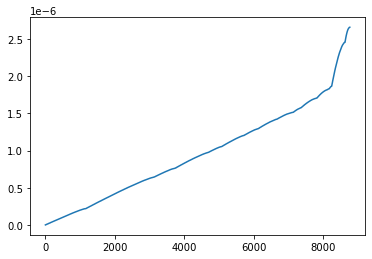

In [ ]:
difs10_ord1 = [fft10[1:] - fft10[:-1] for fft10 in electrical_data[:, :, 3]]
difs10_ord2 = [np.abs(dif10_ord1[1:] - dif10_ord1[:-1]) for dif10_ord1 in difs10_ord1]
print(np.mean(difs10_ord2))
print(np.std(difs10_ord2))
print(np.min(difs10_ord2))
print(np.max(difs10_ord2))
sorted_difs = np.sort(difs10_ord2[35])
plt.plot(sorted_difs)

## Sample Data

In [ ]:
cwgan_gp_sn.generator.load_weights(ckpt_dir + '/generator_weights_500.ckpt')
cwgan_gp_sn.critic.load_weights(ckpt_dir + '/critic_weights_500.ckpt')

NameError: name 'wgangp' is not defined

In [ ]:
path = 'samples_from_model'
nr_samples = 5000
nr_trials = 1000
batch_size = 50
final_samples = [None] * nr_samples
final_scores = [-9999] * nr_samples
sampled_labels = [[randint(0, 3), randint(3, 12), randint(12, 17), randint(17, 20), randint(20, 28)] for _ in range(nr_samples)]
sampled_labels = np.array(sampled_labels)

for k in range(0, 5000, batch_size):
    batch_labels = sampled_labels[k:k + batch_size]
    for i in range(nr_trials):
        noise = np.random.normal(0, 1, (batch_size, cwgan_gp_sn.noise_length))
        gen_samples = cwgan_gp_sn.generator.predict([noise, batch_labels])
        critic_scores = cwgan_gp_sn.critic.predict([gen_samples, batch_labels])
        for j, score in enumerate(critic_scores):
            if score > final_scores[k + j]:
                final_scores[k + j] = score
                final_samples[k + j] = gen_samples[j, :, 0]
    print('Finished for k =', k)

## Remove Noise

In [ ]:
final_samples = np.array(final_samples)
final_scores = np.array(final_scores)

for electrical_value in final_samples:
    new_electrical_value = irfft(rfft(electrical_value)[:1000], n=len(electrical_value))
    electrical_value[4800:5520] = new_electrical_value[4800:5520]

## Save the Data

In [ ]:
np.savez_compressed('../../data/processed/generated_data.npz', electrical_data=final_samples, labels=sampled_labels)